In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import datetime
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Bidirectional, Lambda, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate, Add, Subtract, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import keras.backend as kb
import tensorflow as tf

In [ ]:
q1_train_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q1_train_final.npy", allow_pickle='True')
q2_train_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q2_train_final.npy", allow_pickle='True')
q1_valid_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q1_valid_final.npy", allow_pickle='True')
q2_valid_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q2_valid_final.npy", allow_pickle='True')
y_train_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/y_train_final.npy", allow_pickle='True')
y_valid_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/y_valid_final.npy", allow_pickle='True')

In [ ]:
q1_test_padded = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q1_test_padded.npy", allow_pickle='True')
q2_test_padded = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/q2_test_padded.npy", allow_pickle='True')
y_test = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/y_test.npy", allow_pickle='True')

In [ ]:
embedding_matrix = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/embedding_matrix.npy", allow_pickle='True')

In [ ]:
train_manual_features_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/train_manual_features_final.npy", allow_pickle='True')
valid_manual_features_final = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/valid_manual_features_final.npy", allow_pickle='True')
test_manual_features_npy = np.load("/content/drive/My Drive/Text Mining Project/Train_Valid_Split/test_manual_features_npy.npy", allow_pickle='True')

In [ ]:
train_manual_features_final = train_manual_features_final.astype(dtype='float32')
valid_manual_features_final = valid_manual_features_final.astype(dtype='float32')
test_manual_features_npy = test_manual_features_npy.astype(dtype='float32')

In [ ]:
batch_size=64
n_epochs = 25

In [ ]:
# Input Layer
q1_input = Input(shape=(60,), dtype='int32')
q2_input = Input(shape=(60,), dtype='int32')

# Embedding Layer
embedding_layer = Embedding(input_dim=len(embedding_matrix), output_dim=300, weights=[embedding_matrix], input_length=60, trainable=False)

# The above Embedding layer is shared for both question1 and question2
q1_embed = embedding_layer(q1_input)
q2_embed = embedding_layer(q2_input)

# lSTM layer
lstm_layer = LSTM(units=75, recurrent_dropout=0.25)

# The above LSTM layer is shared for both question1 and question2
q1_lstm = lstm_layer(q1_embed)
q2_lstm = lstm_layer(q2_embed)

'''
We want to find absolute difference between question1 feature and 
question2 feature from final hidden state of LSTM keeping the dimensions same 
'''
subtracted = Subtract()([q1_lstm, q2_lstm])
abs_diff = kb.abs(subtracted)

# Same as above but want to add question1 and question2 features
added = Add()([q1_lstm, q2_lstm])

# Find Euclidean distance squares between question1 and question2 feature
euclidean = Multiply()([subtracted, subtracted])

# Manual Features Processing
manual_features_input = Input(shape=(train_manual_features_final.shape[1],), dtype='float32')
manual_features = BatchNormalization()(manual_features_input)
manual_features = Dense(units=100, activation='relu')(manual_features)

# Concatenate Siamese Network features with above manual features
concatted = Concatenate(axis=-1)([abs_diff, added, euclidean, manual_features])
concatted = BatchNormalization()(concatted)
concatted = Dense(units=500, activation='relu')(concatted)
concatted = Dropout(0.35)(concatted)
concatted = BatchNormalization()(concatted)
concatted = Dense(500, activation="relu")(concatted)
concatted = Dropout(0.5)(concatted)
concatted = BatchNormalization()(concatted)
concatted = Dense(100, activation="relu")(concatted)

# Detect whether given set of questions are duplicate or not
is_duplicate = Dense(1, activation="sigmoid")(concatted)

# Combine into the Model
model = Model(inputs=[q1_input, q2_input, manual_features_input], outputs=is_duplicate)

# Compiling the model
'''
Configurations:
              Loss function used: Binary Cross Entropy
              Optimizer: Nadam
              metrics used: Accuracy
'''
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

'''
Callbacks:
          EarlyStopping to avoid Overfitting
          ModelCheckpoint to save best model in all epochs
          TensorBoard Visulaization for Loss

'''
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/drive/My Drive/Text Mining Project/Saved Model/Callbacks/model.{epoch:02d}-{val_loss:.2f}.h5',
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    TensorBoard(log_dir='/content/drive/My Drive/Text Mining Project/Saved Model/Tensorboard/runs/'),
  ]

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      32414700    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 75)           112800      embedding_1[0][0]     

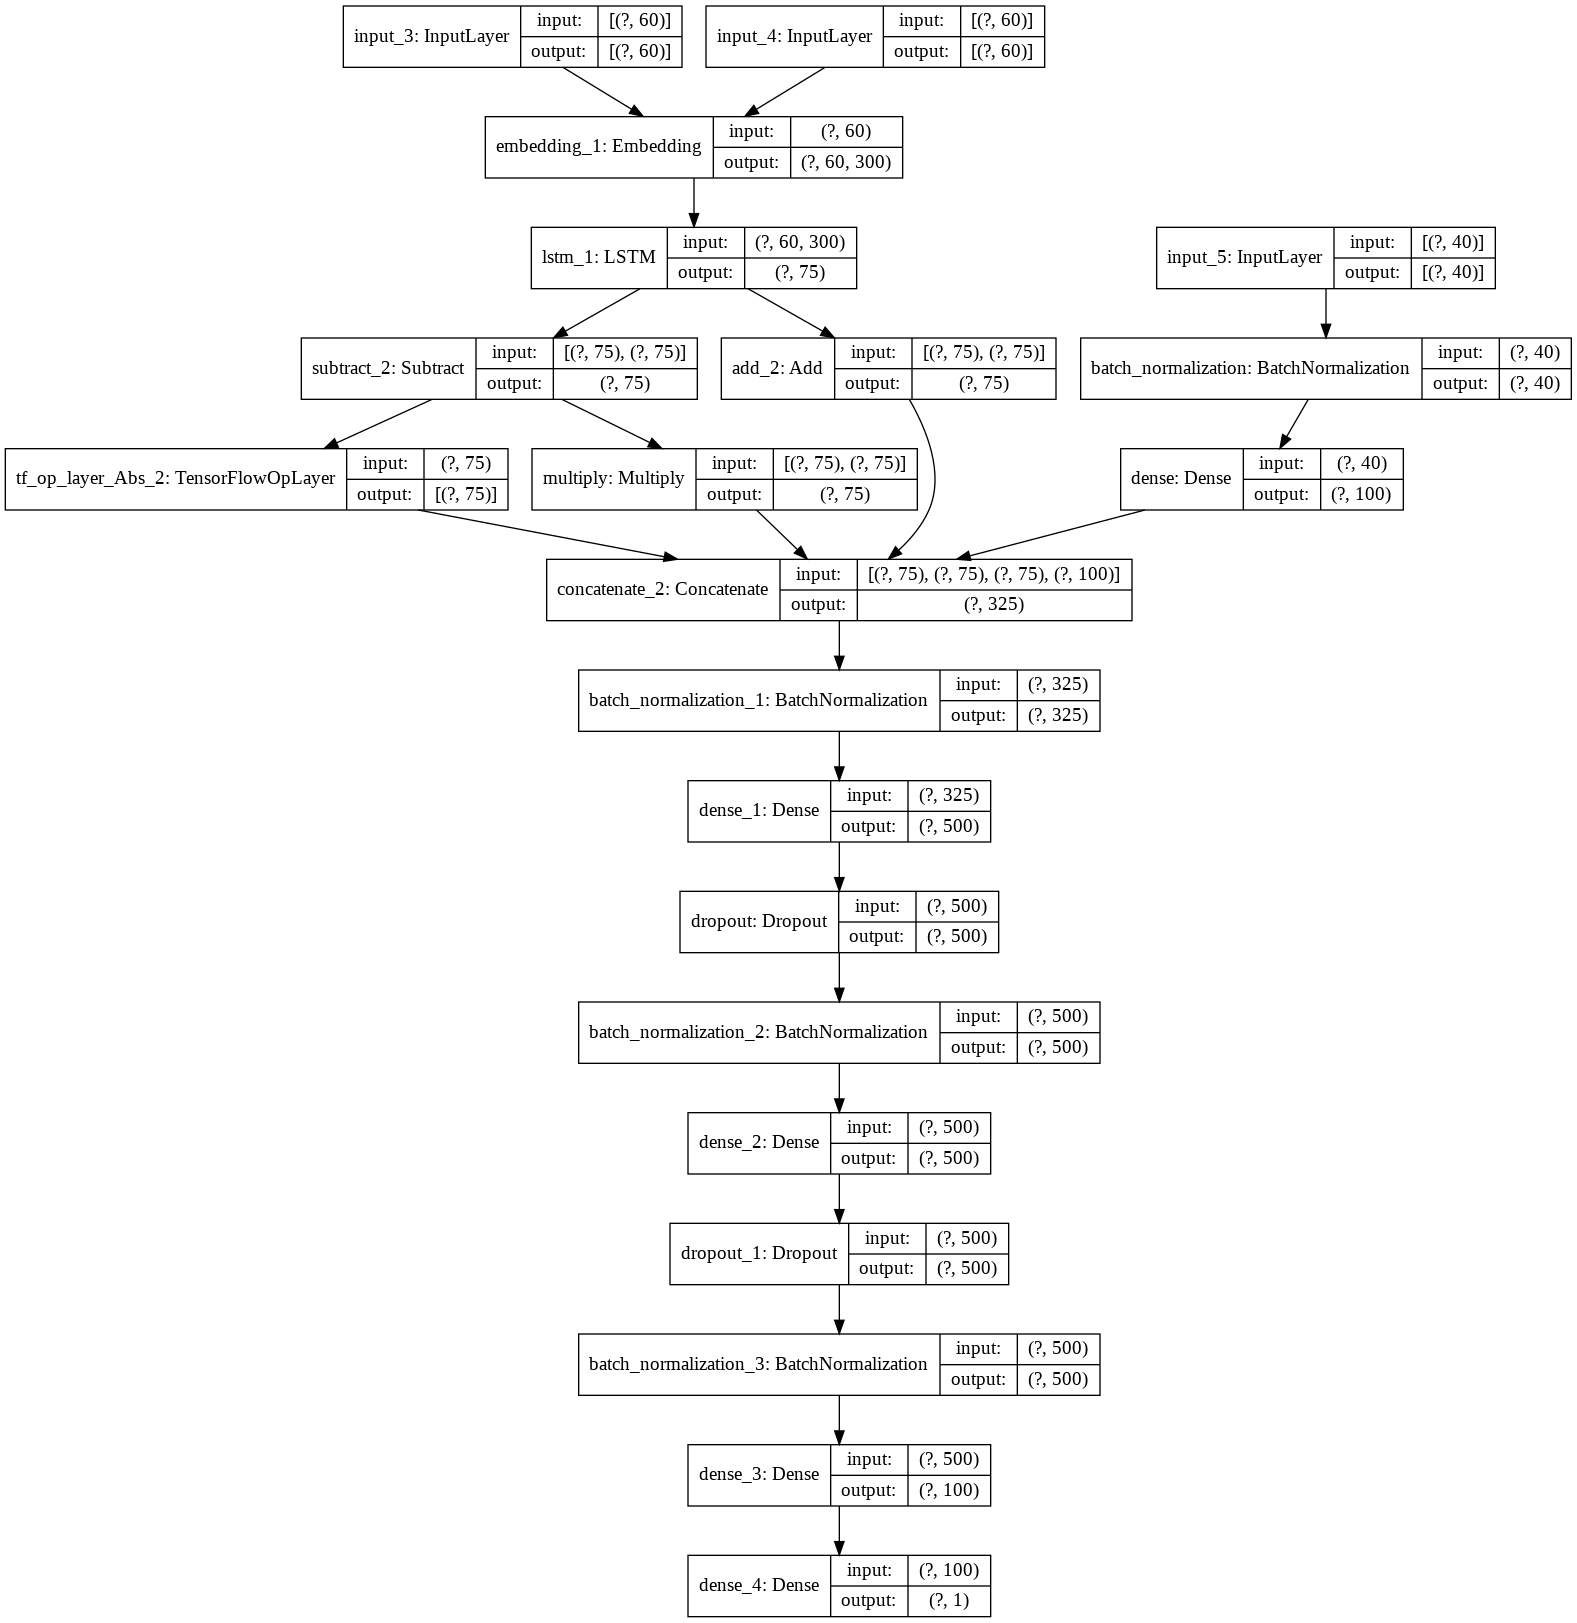

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='Siamese+ManualFeatures.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
start = time.time()
trained_model = model.fit(x=[q1_train_final, q2_train_final, train_manual_features_final], y=y_train_final,
                          validation_data=([q1_valid_final, q2_valid_final, valid_manual_features_final], y_valid_final), 
                          batch_size=batch_size, epochs=n_epochs, 
                          callbacks=my_callbacks
                          )
end = time.time()
print(f"Time taken to train {n_epochs} epochs is {datetime.timedelta(seconds=int(end-start))}")

Epoch 1/25
   1/5536 [..............................] - ETA: 0s - loss: 1.0406 - accuracy: 0.4062WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5536/5536 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8656
Epoch 00001: val_loss improved from inf to 0.24122, saving model to /content/drive/My Drive/Text Mining Project/Saved Model/Callbacks/model.01-0.24.h5
5536/5536 [==============================] - 1648s 298ms/step - loss: 0.2849 - accuracy: 0.8656 - val_loss: 0.2412 - val_accuracy: 0.8887
Epoch 2/25
5536/5536 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.8888
Epoch 00002: val_loss improved from 0.24122 to 0.22717, saving model to /content/drive/My Drive/Text Mining Project/Saved Model/Callbacks/model.02-0.23

In [ ]:
# model.save('/content/drive/My Drive/Text Mining Project/Saved Model/myModel.h5', overwrite=True, include_optimizer=True)
# model.save_weights('/content/drive/My Drive/Text Mining Project/Saved Model/myModel.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/drive/My Drive/Text Mining Project/Saved Model/myModel.h5')
model.load_weights("/content/drive/My Drive/Text Mining Project/Saved Model/myModel.h5")

In [ ]:
y_pred = model.predict([q1_test_padded, q2_test_padded, test_manual_features_npy])

In [ ]:
def prob_to_classes(y_pred, threshold=0.5):
  global y_test
  predicted_classes = np.empty_like(y_test)
  for i in range(len(y_pred)):
    if y_pred[i][0] >= threshold:
      predicted_classes[i] = 1
    else:
      predicted_classes[i] = 0
  return predicted_classes

In [ ]:
predicted_classes = prob_to_classes(y_pred, threshold=0.5)

In [ ]:
acc = np.sum(predicted_classes == y_test)/len(y_test)
print(f"Accuracy = {acc}")

Accuracy = 0.9053


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      6308
           1       0.90      0.84      0.87      3692

    accuracy                           0.91     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.91      0.90     10000

